# Analysis of material properties of mitochondrial membranes

## Loading and setup

In [1]:
%load_ext autoreload


In [2]:
%matplotlib inline
%autoreload 1
import pickle
import numpy as np
from functools import partial
import MDAnalysis

from pathlib import Path

import matplotlib.pyplot as plt
import numpy.typing as npt

import pandas as pd

from scipy import integrate, interpolate, stats
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

%aimport util
from plot_helper import *


Matplotlib Version: 3.6.3


# Lateral Pressures

In [3]:
def first_cubic_np(z, lp, minz=None, maxz=None, maxiter=5000, sym: bool = True):
    """
    Compute the first moment using a cubic piecewise interpolant and Gaussian quadrature
    """
    lp = lp / 1e3  # to convert to piconewtons / nm^2

    if sym:
        if len(lp) % 2 == 1:
            s = int(np.floor(len(lp) / 2))
            bot, mid, top = np.split(lp, [s, s + 1])
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            lp = np.hstack((sym_bot, mid, sym_top))
        else:
            bot, top = np.split(lp, 2)
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            lp = np.hstack((sym_bot, sym_top))

    y = lp * z

    if minz is None:
        minz = min(z)
    if maxz is None:
        maxz = max(z)

    approx = interpolate.interp1d(z, y, kind="cubic")  # interpolating a function
    intg = integrate.quadrature(
        approx, minz, maxz, maxiter=maxiter
    )  # finding the integral over bounds
    return intg


def zero_cubic_np(z, lp, minz=None, maxz=None, maxiter=5000, sym: bool = True):
    """
    Compute the zeroeth moment using a cubic piecewise interpolant and Gaussian quadrature
    """
    # p = data['LP_(kPA)']/1e15 # to convert to newtons / nm^2
    lp = lp / 1e3  # to convert to piconewtons / nm^2

    if sym:
        if len(lp) % 2 == 1:
            s = int(np.floor(len(lp) / 2))
            bot, mid, top = np.split(lp, [s, s + 1])
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            lp = np.hstack((sym_bot, mid, sym_top))
        else:
            bot, top = np.split(lp, 2)
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            lp = np.hstack((sym_bot, sym_top))

    if minz is None:
        minz = min(z)
    if maxz is None:
        maxz = max(z)

    approx = interpolate.interp1d(z, lp, kind="cubic")  # interpolating a function
    intg = integrate.quadrature(
        approx, minz, maxz, maxiter=maxiter
    )  # finding the integral over bounds
    return intg


def mean_squared_deviation_np(data: npt.ArrayLike) -> float:
    """
    Compute the mean squared deviation of the data
    """
    return sum(data ** 2) / (data.size - 1)


def max_difference(a: npt.ArrayLike, b: npt.ArrayLike):
    """
    Get the max difference between two equal sized arrays
    """
    if a.size != b.size:
        raise RuntimeError("a and b must be same sized arrays")
    diff = np.abs(a - b)
    return np.amax(diff)


In [4]:
from LStensor import LStensor


# Override and recompute even if spectra pickle exists
lp_compute_override = False

lp_fd = util.analysis_path / "lp.pickle"


if lp_fd.exists() and not lp_compute_override:
    # LOAD LP pickle
    with open(lp_fd, "rb") as handle:
        lateral_pressure = pickle.load(handle)
    print("Loaded LP from cache")

else:
    lateral_pressure = {}

    for sim in util.simulations:
        fd = Path(util.analysis_path /  f"{sim}_small/stress_calc/frames/frame0.dat0")
        field = LStensor(2)
        field.g_loaddata(files=[fd], bAvg="avg")

        # stress_tensor = np.empty((20000, field.nz, 9))
        lateral_pressure[sim] = np.empty((40000, field.nz, 3))

        # 0-20000 frames in each trajectory
        for i, j in enumerate(range(1, 40001)):
            fd = Path(util.analysis_path / f"{sim}_small/stress_calc/frames/frame{j}.dat0")
            field = LStensor(2)
            field.g_loaddata(files=[fd], bAvg="avg")
            stress_tensor = field.data_grid * 100   # Convert to kPa from 10^5 Pa
            # Sxx Sxy Sxz Syx Syy Syz Szx Szy Szz
            # 0               4               8

            pXY = -0.5*(stress_tensor[:,0] + stress_tensor[:,4]).reshape(-1,1)
            pN = (-stress_tensor[:,8]).reshape(-1,1)
            lp = pXY - pN
            z = (np.arange(field.nz) * field.dz - (field.nz - 1) * field.dz / 2).reshape(-1,1)
            lateral_pressure[sim][i] = np.hstack((pN, lp, z))
    
    # WRITE LP TO PICKLE
    with open(lp_fd, "wb") as handle:
        pickle.dump(lateral_pressure, handle, protocol=pickle.HIGHEST_PROTOCOL)


Loaded LP from cache


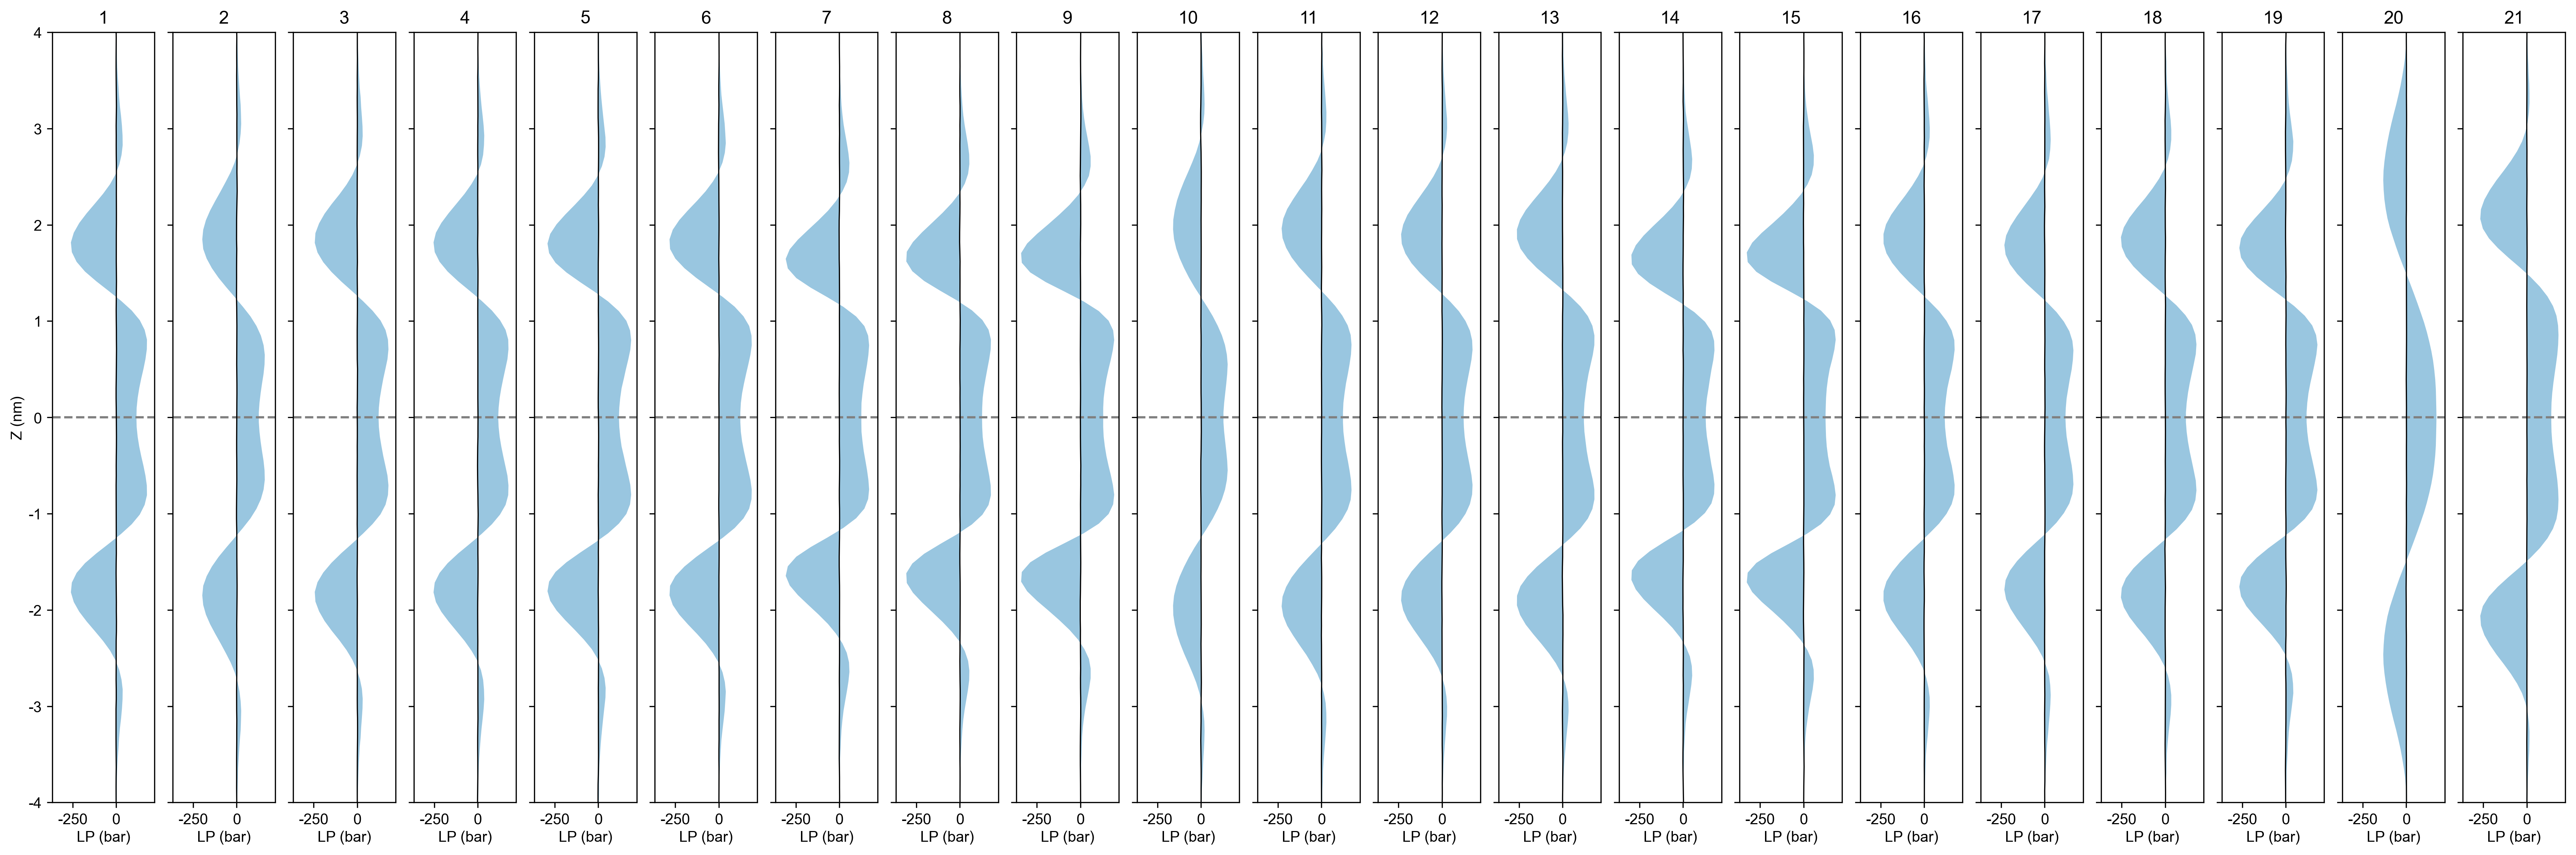

In [5]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

k = 3 

fig, ax = plt.subplots(1, len(util.remapping_order), figsize=(24, 8), sharex=True, sharey=True)
for sim_new in range(1, len(util.remapping_order) + 1):
    ax_index = int(sim_new) - 1
    sim = util.remapping_dict[sim_new]
    
    ax[ax_index].axhline(0, linestyle="--", color="gray")

    # k_fold_data = np.array_split(lateral_pressure[sim], k, axis=0)

    # split_data = []
    # for split in k_fold_data:
    #     # print(split.shape)
    #     split_data.append(np.mean(split, axis=0))

    data = np.mean(lateral_pressure[sim], axis=0)

    # for data in split_data:
    z = data[:, 2]

    ax[ax_index].plot(
        data[:,0] * 0.01,
        z,
        label="Normal Stress",
        linewidth=NORMAL_LINE,
        linestyle="-",
        color="k",
    )

    lateral = data[:, 1] * 0.01  # bar

    # Symmetrizing
    if len(lateral) % 2 == 1:
        s = int(np.floor(len(lateral) / 2))
        bot, mid, top = np.split(lateral, [s, s + 1])
        sym_top = (np.flip(bot) + top) / 2
        sym_bot = np.flip(sym_top)
        sym_lp = np.hstack((sym_bot, mid, sym_top))
    else:
        bot, top = np.split(lateral, 2)
        sym_top = (np.flip(bot) + top) / 2
        sym_bot = np.flip(sym_top)
        sym_lp = np.hstack((sym_bot, sym_top))

        # ax[ax_index].plot(
        #     sym_lp,
        #     z,
        #     label="Lateral Pressure",
        #     linewidth=NORMAL_LINE,
        #     linestyle="-",
        # )  # alpha=0.4,

    ax[ax_index].fill_betweenx(
        z,
        sym_lp,
        0,
        label="Lateral Pressure",
        alpha=0.4
    )

    ax[ax_index].set_ylim(-4, 4)
    # ax[x,y].ticklabel_format(axis = 'x', style = 'sci', scilimits = (0,0))
    ax[ax_index].set_xlabel("LP (bar)")
    ax[ax_index].set_title(f"{sim_new}")
    if ax_index == 0:
        ax[ax_index].set_ylabel("Z (nm)")

# handles = [
#     mlines.Line2D([], [], color="black", linestyle=":", label="Normal Stress"),
#     mlines.Line2D(
#         [],
#         [],
#         color="black",
#         linestyle="-",
#         label="Lateral Stress",
#     ),
# ]

# plt.legend(handles=handles, bbox_to_anchor=(-2.5, -0.95, 0.8, 0.8), ncol=2)
plt.tight_layout()


fig.savefig(curr_fig_path / "stress.pdf", format="pdf")
fig.savefig(curr_fig_path / "stress.png", format="png")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


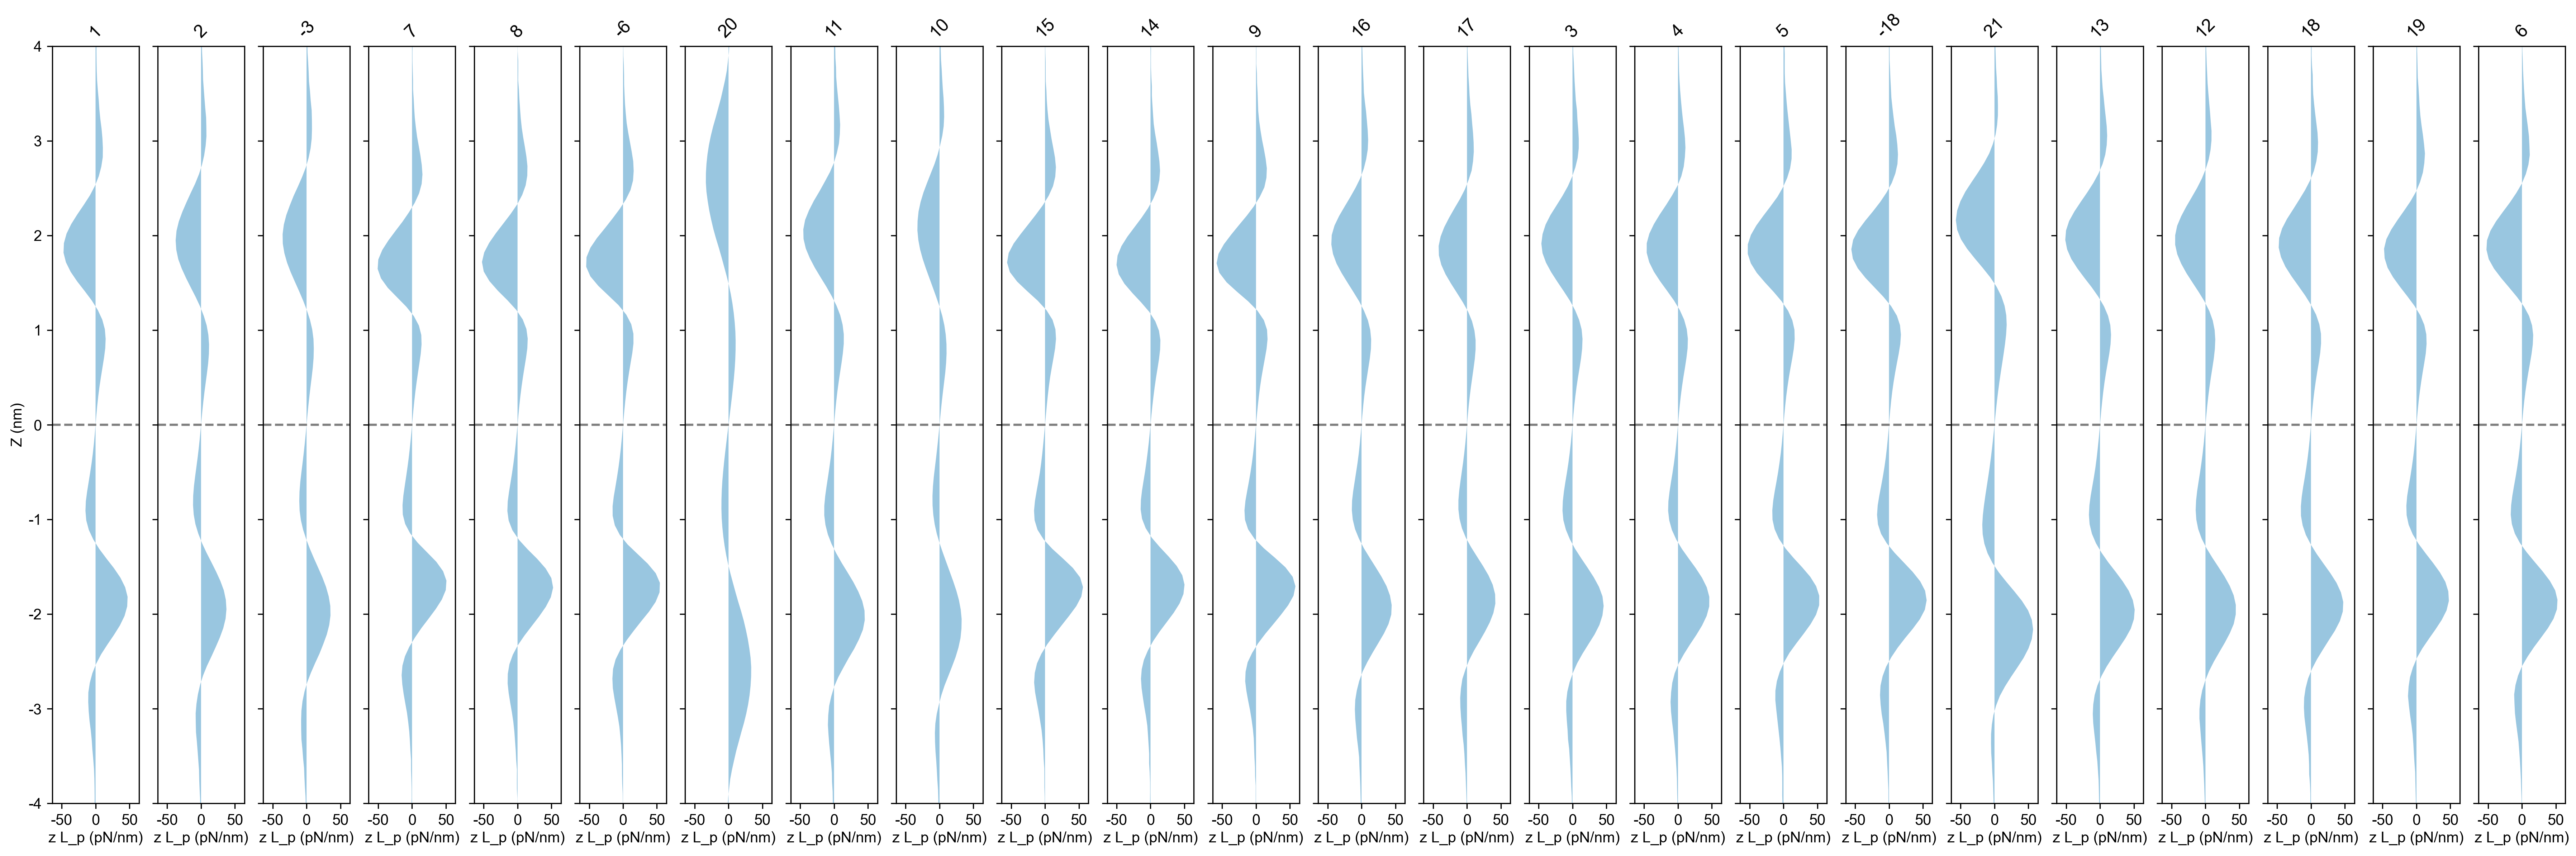

In [6]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)



fig, ax = plt.subplots(1, 24, figsize=(24, 8), sharex=True, sharey=True)
for sim in util.simulations:
    ax_index = int(sim) - 1
    ax[ax_index].axhline(0, linestyle="--", color="gray")

    data = np.mean(lateral_pressure[sim], axis=0)
    z = data[:, 2]

    lateral = data[:,1] / 1e3 # pN/nm^2
    # Symmetrizing
    if len(lateral) % 2 == 1:
        s = int(np.floor(len(lateral) / 2))
        bot, mid, top = np.split(lateral, [s, s + 1])
        sym_top = (np.flip(bot) + top) / 2
        sym_bot = np.flip(sym_top)
        sym_lp = np.hstack((sym_bot, mid, sym_top))
    else:
        bot, top = np.split(lateral, 2)
        sym_top = (np.flip(bot) + top) / 2
        sym_bot = np.flip(sym_top)
        sym_lp = np.hstack((sym_bot, sym_top))

    ax[ax_index].fill_betweenx(z, z*sym_lp, 0, label="Lateral Stress", alpha=0.4)

    ax[ax_index].set_ylim(-4, 4)
    # ax[x,y].ticklabel_format(axis = 'x', style = 'sci', scilimits = (0,0))
    ax[ax_index].set_xlabel("z L_p (pN/nm)")
    ax[ax_index].set_title(f"{util.sim_to_final_index[sim]}", rotation=45)
    if ax_index == 0:
        ax[ax_index].set_ylabel("Z (nm)")

# handles = [
#     mlines.Line2D([], [], color="black", linestyle=":", label="Normal Stress"),
#     mlines.Line2D(
#         [],
#         [],
#         color="black",
#         linestyle="-",
#         label="Lateral Stress",
#     ),
# ]

# plt.legend(handles=handles, bbox_to_anchor=(-2.5, -0.95, 0.8, 0.8), ncol=2)
plt.tight_layout()

fig.savefig(curr_fig_path / "first_mom_integrand.png", format="png")

if show_figs:
    plt.show()
fig.clear()
plt.close(fig)


In [7]:
show_figs = False

k = 3 # Number of sections to split data into

f_cubic_dat = {}
z_cubic_dat = {}
msd_dat = {}

for sim in util.simulations:
    k_fold_data = np.array_split(lateral_pressure[sim], k, axis=0)

    data = []
    for split in k_fold_data:
        print(split.shape)
        data.append(np.mean(split, axis=0))

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    fcd = np.zeros(k)
    for i, d in enumerate(data):
        z = d[:, 2]
        lateral = d[:,1]

        # Symmetrizing
        if len(lateral) % 2 == 1:
            s = int(np.floor(len(lateral) / 2))
            bot, mid, top = np.split(lateral, [s, s + 1])
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            sym_lp = np.hstack((sym_bot, mid, sym_top))
        else:
            bot, top = np.split(lateral, 2)
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            sym_lp = np.hstack((sym_bot, sym_top))

        ax.plot(sym_lp, z, label="Lateral Pressure", alpha=0.4)

        fcd[i] = (first_cubic_np(z, sym_lp, maxz=0)[0] - first_cubic_np(z, sym_lp, minz=0)[0]) / 2
    f_cubic_dat[sim] = (np.mean(fcd), np.std(fcd))
    print(sim, fcd, f_cubic_dat[sim])

    ax.set_ylim(-4, 4)
    
    plt.tight_layout()

    # fig.savefig(curr_fig_path / "first_mom_integrand.png", format="png")

    if show_figs:
        plt.show()
    fig.clear()
    plt.close(fig)


(13334, 239, 3)
(13333, 239, 3)
(13333, 239, 3)
1 [16.59469922 14.55668819 16.94720107] (16.03286282437595, 1.0536865621641713)
(13334, 246, 3)
(13333, 246, 3)
(13333, 246, 3)
2 [17.52726536 15.83330157 18.26359158] (17.20805283906782, 1.0175132614673912)
(13334, 245, 3)
(13333, 245, 3)
(13333, 245, 3)
3 [14.40764142 16.55763774 15.77397017] (15.579749778219139, 0.8884113996045878)
(13334, 258, 3)
(13333, 258, 3)
(13333, 258, 3)
4 [13.3438027  12.4423631  12.62415984] (12.803441878734608, 0.38923418458540543)
(13334, 259, 3)
(13333, 259, 3)
(13333, 259, 3)
5 [15.24026407 14.74404498 14.96380343] (14.98270415952958, 0.20302097290977134)
(13334, 262, 3)
(13333, 262, 3)
(13333, 262, 3)
6 [12.62684218 13.15516208 15.95883532] (13.913613195348134, 1.4621857253141024)
(13334, 167, 3)
(13333, 167, 3)
(13333, 167, 3)
7 [35.42594531 33.34649389 35.18818992] (34.65354304080213, 0.929306198632866)
(13334, 236, 3)
(13333, 236, 3)
(13333, 236, 3)
8 [20.64406544 21.68749991 21.20471021] (21.17875852

In [8]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    
pal = sns.color_palette("colorblind")
bar_props = [
    (1, 1, None),
    (3, 1, None),
    (2, 1.1, None),
    (2, 0.95, "///"),
]


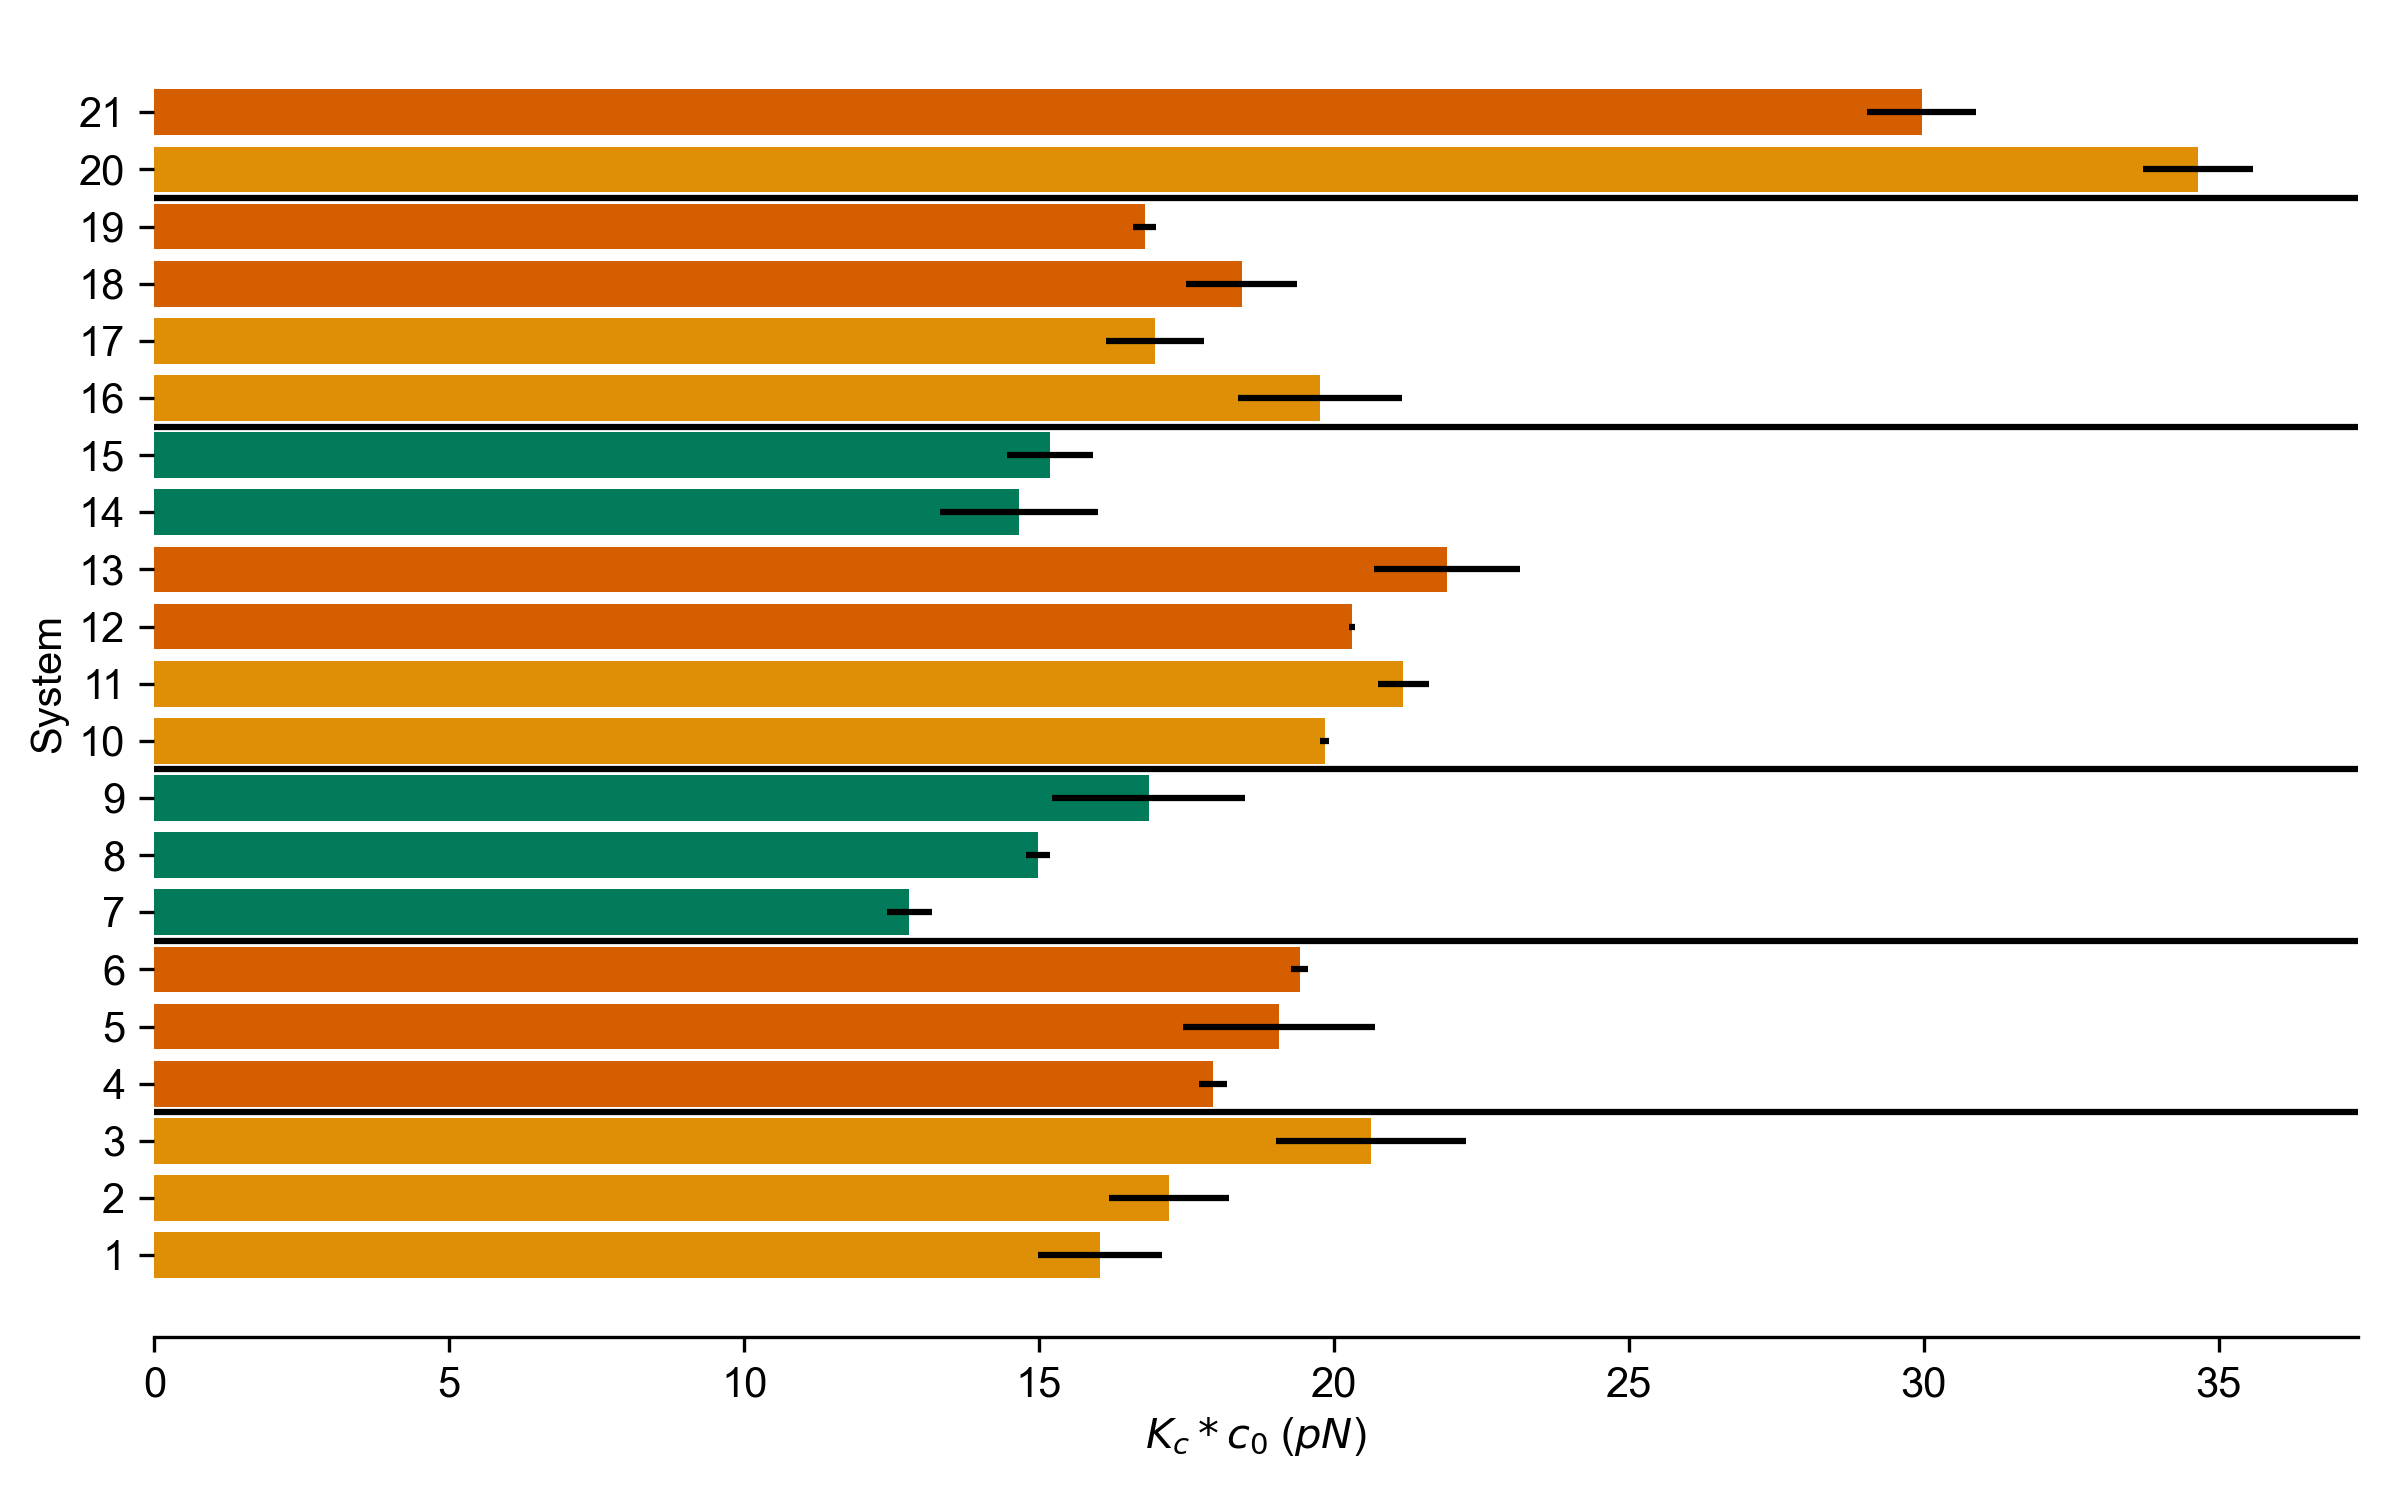

In [9]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(1, 4):
    ax.barh(str(i), f_cubic_dat[util.remapping_dict[i]][0], xerr=f_cubic_dat[util.remapping_dict[i]][1], color = pal[1],  height=0.8)

for i in range(4, 7):
    ax.barh(str(i), f_cubic_dat[util.remapping_dict[i]][0], xerr=f_cubic_dat[util.remapping_dict[i]][1], color = pal[3],  height=0.8)

for i in range(7, 10):
    ax.barh(str(i), f_cubic_dat[util.remapping_dict[i]][0], xerr=f_cubic_dat[util.remapping_dict[i]][1], color = lighten_color(pal[2], 1.1),  height=0.8)

for i in range(10, 12):
    ax.barh(str(i), f_cubic_dat[util.remapping_dict[i]][0], xerr=f_cubic_dat[util.remapping_dict[i]][1], color = pal[1], height=0.8)

for i in range(12,14):
    ax.barh(str(i), f_cubic_dat[util.remapping_dict[i]][0], xerr=f_cubic_dat[util.remapping_dict[i]][1], color = pal[3], height=0.8)

for i in range(14,16):
    ax.barh(str(i), f_cubic_dat[util.remapping_dict[i]][0], xerr=f_cubic_dat[util.remapping_dict[i]][1], color = lighten_color(pal[2], 1.1), height=0.8)


for i in range(16, 18):
    ax.barh(str(i), f_cubic_dat[util.remapping_dict[i]][0], xerr=f_cubic_dat[util.remapping_dict[i]][1], color = pal[1],  height=0.8)


for i in range(18, 20):
    ax.barh(str(i)
    , f_cubic_dat[util.remapping_dict[i]][0], xerr=f_cubic_dat[util.remapping_dict[i]][1], color = pal[3], height=0.8)


ax.barh("20", f_cubic_dat[util.remapping_dict[20]][0], xerr=f_cubic_dat[util.remapping_dict[20]][1], color = pal[1],  height=0.8)

ax.barh("21", f_cubic_dat[util.remapping_dict[21]][0], xerr=f_cubic_dat[util.remapping_dict[21]][1], color = pal[3],height=0.8)


ax.axhline(2.5, color="k")
ax.axhline(5.5, color="k")
ax.axhline(8.5, color="k")
ax.axhline(14.5, color="k")
ax.axhline(18.5, color="k")

ax.set_xlabel(r"$K_c*c_0$ ($pN$)")
ax.set_ylabel(r"System")

# ax.set_xlim(0,40)

# ax.set_xticklabels(
#     ax.get_xticks(),
# )

# x_ticks_labels = [f"{sim}" for sim in range(1,22)]

# Set number of ticks for x-axis
# ax.set_xticks(range(21))
# Set ticks labels for x-axis
# ax.set_xticklabels(x_ticks_labels)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

fig.tight_layout()

fig.savefig(curr_fig_path / f"first_moment_all.png", format="png")
fig.savefig(curr_fig_path / f"first_moment_all.pdf", format="pdf")

if show_figs:
    plt.show()

fig.clear()
plt.close(fig)


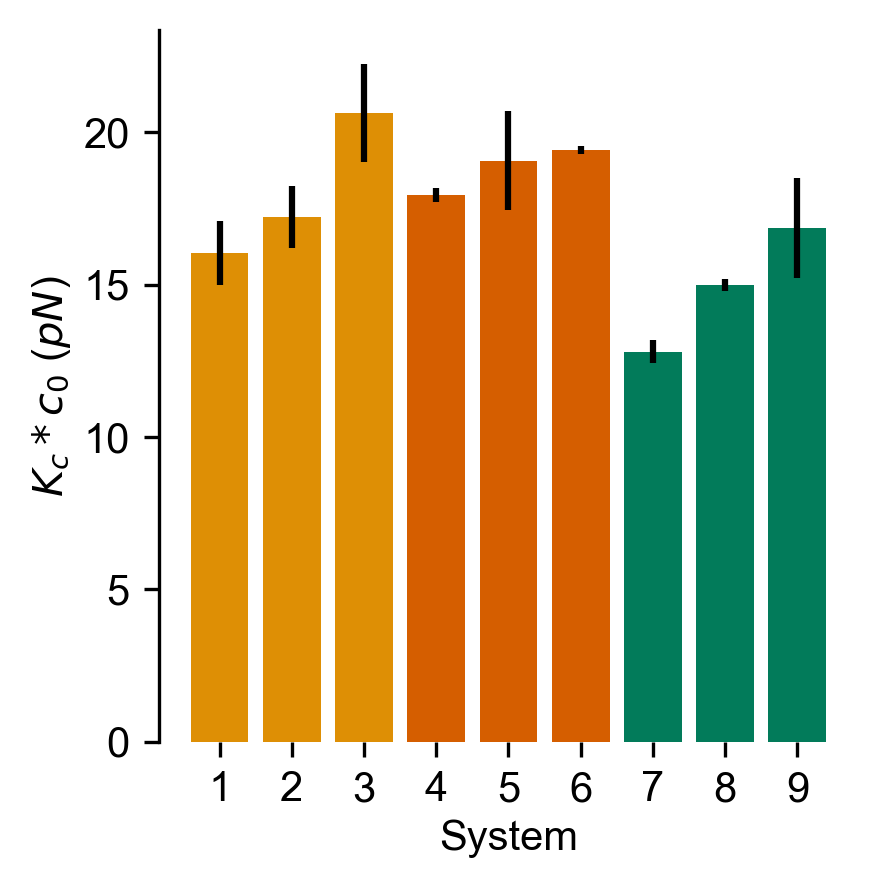

In [26]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

for i in range(1, 4):
    ax.bar(str(i), f_cubic_dat[util.remapping_dict[i]][0], yerr=f_cubic_dat[util.remapping_dict[i]][1], color = pal[1], )

for i in range(4, 7):
    ax.bar(str(i), f_cubic_dat[util.remapping_dict[i]][0], yerr=f_cubic_dat[util.remapping_dict[i]][1], color = pal[3], )

for i in range(7, 10):
    ax.bar(str(i), f_cubic_dat[util.remapping_dict[i]][0], yerr=f_cubic_dat[util.remapping_dict[i]][1], color = lighten_color(pal[2], 1.1), )

ax.set_ylabel(r"$K_c*c_0$ ($pN$)")
ax.set_xlabel(r"System")

# ax.set_xlim(0,40)

# ax.set_xticklabels(
#     ax.get_xticks(),
# )

# x_ticks_labels = [f"{sim}" for sim in range(1,22)]

# Set number of ticks for x-axis
# ax.set_xticks(range(21))
# Set ticks labels for x-axis
# ax.set_xticklabels(x_ticks_labels)

# ax.axhline(2.5, color="k")
# ax.axhline(5.5, color="k")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

fig.tight_layout()

fig.savefig(curr_fig_path / f"first_moment_1-9.png", format="png")
fig.savefig(curr_fig_path / f"first_moment_1-9.pdf", format="pdf")

if show_figs:
    plt.show()

fig.clear()
plt.close(fig)


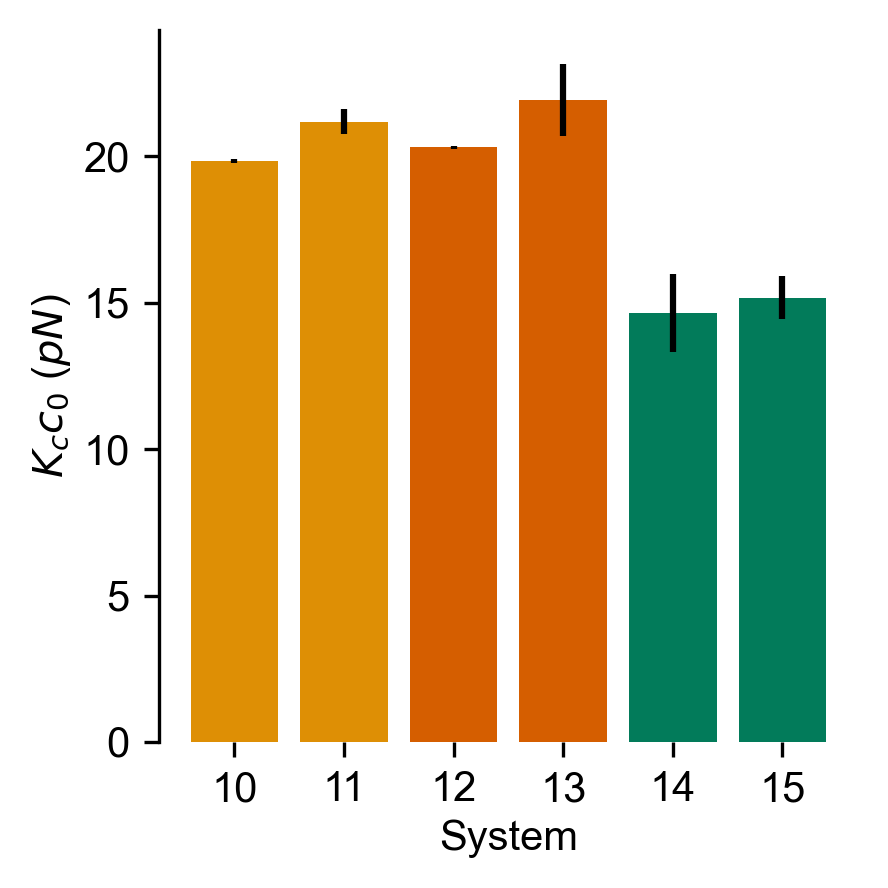

In [24]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

for i in range(10, 12):
    ax.bar(str(i), f_cubic_dat[util.remapping_dict[i]][0], yerr=f_cubic_dat[util.remapping_dict[i]][1], color = pal[1], )

for i in range(12,14):
    ax.bar(str(i), f_cubic_dat[util.remapping_dict[i]][0], yerr=f_cubic_dat[util.remapping_dict[i]][1], color = pal[3], )

for i in range(14,16):
    ax.bar(str(i), f_cubic_dat[util.remapping_dict[i]][0], yerr=f_cubic_dat[util.remapping_dict[i]][1], color = lighten_color(pal[2], 1.1), )

ax.set_ylabel(r"$K_cc_0$ ($pN$)")
ax.set_xlabel(r"System")

# ax.set_xlim(0,40)

# ax.set_xticklabels(
#     ax.get_xticks(),
# )

# x_ticks_labels = [f"{sim}" for sim in range(1,22)]

# Set number of ticks for x-axis
# ax.set_xticks(range(21))
# Set ticks labels for x-axis
# ax.set_xticklabels(x_ticks_labels)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

fig.tight_layout()

fig.savefig(curr_fig_path / f"first_moment_10-15.png", format="png")
fig.savefig(curr_fig_path / f"first_moment_10-15.pdf", format="pdf")

if show_figs:
    plt.show()

fig.clear()
plt.close(fig)


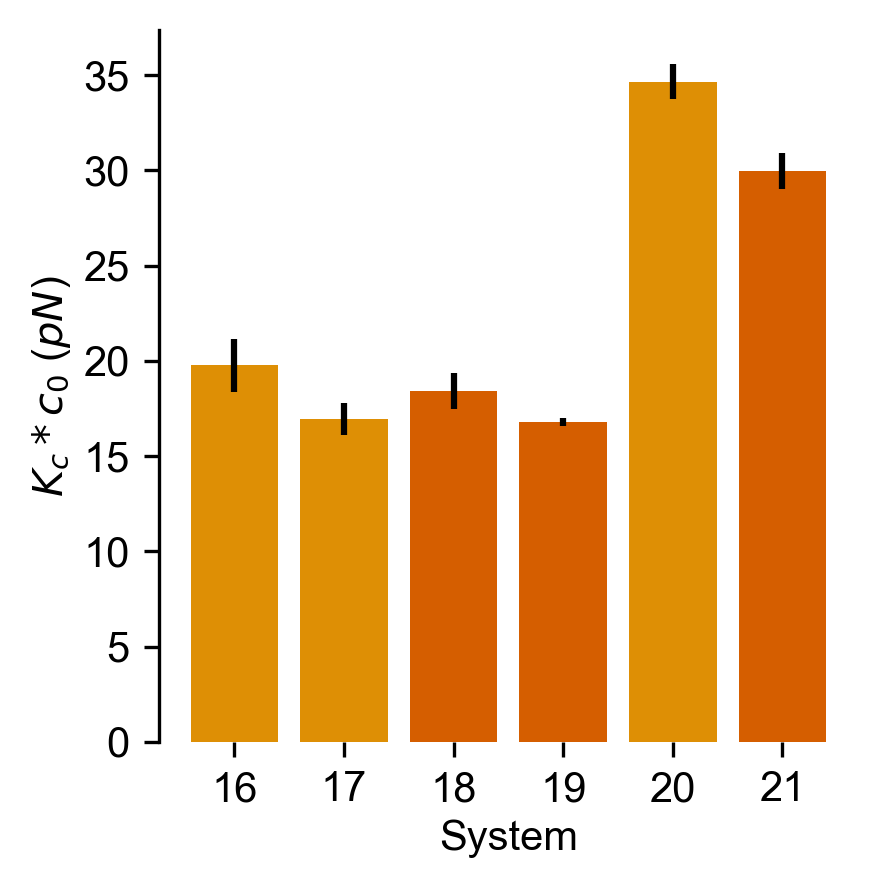

In [33]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))

for i in range(16, 18):
    ax.bar(str(i), f_cubic_dat[util.remapping_dict[i]][0], yerr=f_cubic_dat[util.remapping_dict[i]][1], color = pal[1], )

for i in range(18, 20):
    ax.bar(str(i)
    , f_cubic_dat[util.remapping_dict[i]][0], yerr=f_cubic_dat[util.remapping_dict[i]][1], color = pal[3],)


ax.bar("20", f_cubic_dat[util.remapping_dict[20]][0], yerr=f_cubic_dat[util.remapping_dict[20]][1], color = pal[1], )

ax.bar("21", f_cubic_dat[util.remapping_dict[21]][0], yerr=f_cubic_dat[util.remapping_dict[21]][1], color = pal[3],)


ax.set_ylabel(r"$K_c*c_0$ ($pN$)")
ax.set_xlabel(r"System")

# ax.set_xlim(0,40)

# ax.set_xticklabels(
#     ax.get_xticks(),
# )

# x_ticks_labels = [f"{sim}" for sim in range(1,22)]

# Set number of ticks for x-axis
# ax.set_xticks(range(21))
# Set ticks labels for x-axis
# ax.set_xticklabels(x_ticks_labels)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

fig.tight_layout()

fig.savefig(curr_fig_path / f"first_moment_16-21.png", format="png")
fig.savefig(curr_fig_path / f"first_moment_16-21.pdf", format="pdf")

if show_figs:
    plt.show()

fig.clear()
plt.close(fig)


In [12]:
for sim in range(1,22):
    print(f"{sim}	{f_cubic_dat[util.remapping_dict[sim]][0]}	{f_cubic_dat[util.remapping_dict[sim]][1]}")


1	16.03286282437595	1.0536865621641713
2	17.20805283906782	1.0175132614673912
3	20.629835253989757	1.607638384357882
4	17.947104297083634	0.23535776490290755
5	19.06476717044786	1.6227410774853286
6	19.416600578312067	0.1434981442766038
7	12.803441878734608	0.38923418458540543
8	14.98270415952958	0.20302097290977134
9	16.85631471842346	1.6368070225401494
10	19.84129800631053	0.07615494354665889
11	21.178758520273263	0.42637541322155437
12	20.312239833515836	0.05191382041136485
13	21.92038363454614	1.2398760893969238
14	14.654925696753708	1.3392816737315514
15	15.180519240533705	0.727955718565714
16	19.76287249559921	1.3931045151921833
17	16.96357984030202	0.8305041742152982
18	18.43516182652797	0.9423628440691832
19	16.791800380990967	0.1916277510501
20	34.65354304080213	0.929306198632866
21	29.962666832461675	0.9233429929144388


In [13]:
kc_mean_std = np.load('kc_mean_std.npy', allow_pickle=True).item()
print(kc_mean_std)
for sim in range(1,22):
    remapped = util.remapping_dict[sim]
    print(sim, kc_mean_std[remapped])


{1: [7.515523563178702, 0.28538612846793077], 2: [7.522590863449551, 0.24561114172339582], 3: [8.900610646334401, 0.38341348730793356], 4: [16.234750107095966, 0.25335325791843755], 5: [16.099580874049362, 0.2938325024409144], 6: [16.34392131775468, 0.287639066285132], 7: [4.861780732524772, 0.14720001331012073], 8: [6.279132089529996, 0.22687627588292877], 9: [5.6667575348040895, 0.2611765785735877], 10: [18.645693290063328, 0.2563411112578197], 11: [15.117594628557093, 0.20993880026590506], 12: [15.778474074475126, 0.2403590316769071], 13: [6.8827220157863955, 0.32416898736005756], 14: [10.06346365282675, 0.2716760769013437], 15: [8.496440130327809, 0.28584955796844536], 16: [10.364816123591735, 0.2779748810509017], 17: [10.862922033711145, 0.2961628915202576], 18: [11.945565721702348, 0.2944359265943328], 19: [11.552181004269604, 0.2360320111757179], 20: [12.55263334394443, 0.3069466797119359], 21: [10.307719110101106, 0.32259686483741246], 22: [8.787156672751227, 0.3258146246373774

In [14]:
c0 = {}
one_over_c0 = {}
for sim in range(1,22):
    remapped = util.remapping_dict[sim]
    value = f_cubic_dat[remapped][0]/(kc_mean_std[remapped][0] * 4.18336647)
    error = np.sqrt((f_cubic_dat[remapped][1]/f_cubic_dat[remapped][0])**2 + (kc_mean_std[remapped][1]/kc_mean_std[remapped][0])**2) * value

    c0[sim] = (value, error) 

    one_over_c0[sim] = (1/value, error/value/value)

    print(f"System {sim} c0: {value: 0.3f} +/- {error:0.3f} nm^-1; {1 / value} +/- {error/value/value} nm")


System 1 c0:  0.510 +/- 0.039 nm^-1; 1.9609841126374423 +/- 0.14884262706826523 nm
System 2 c0:  0.547 +/- 0.037 nm^-1; 1.8287806691432704 +/- 0.1235256310008862 nm
System 3 c0:  0.580 +/- 0.049 nm^-1; 1.7229280950608523 +/- 0.1462422857872209 nm
System 4 c0:  0.414 +/- 0.012 nm^-1; 2.41597884100974 +/- 0.07212574868196062 nm
System 5 c0:  0.420 +/- 0.037 nm^-1; 2.383642212661959 +/- 0.21304291465533104 nm
System 6 c0:  0.407 +/- 0.011 nm^-1; 2.4550339012271123 +/- 0.06894835426530127 nm
System 7 c0:  0.189 +/- 0.006 nm^-1; 5.304504045873518 +/- 0.18126667567997617 nm
System 8 c0:  0.222 +/- 0.005 nm^-1; 4.495213019788148 +/- 0.1021817386216857 nm
System 9 c0:  0.255 +/- 0.025 nm^-1; 3.915870134934041 +/- 0.3848952390133638 nm
System 10 c0:  0.837 +/- 0.039 nm^-1; 1.194786926600243 +/- 0.05525744671317446 nm
System 11 c0:  0.806 +/- 0.033 nm^-1; 1.2402951107306877 +/- 0.05130104726541018 nm
System 12 c0:  0.471 +/- 0.015 nm^-1; 2.1229055417228904 +/- 0.06666096050138857 nm
System 13 c0

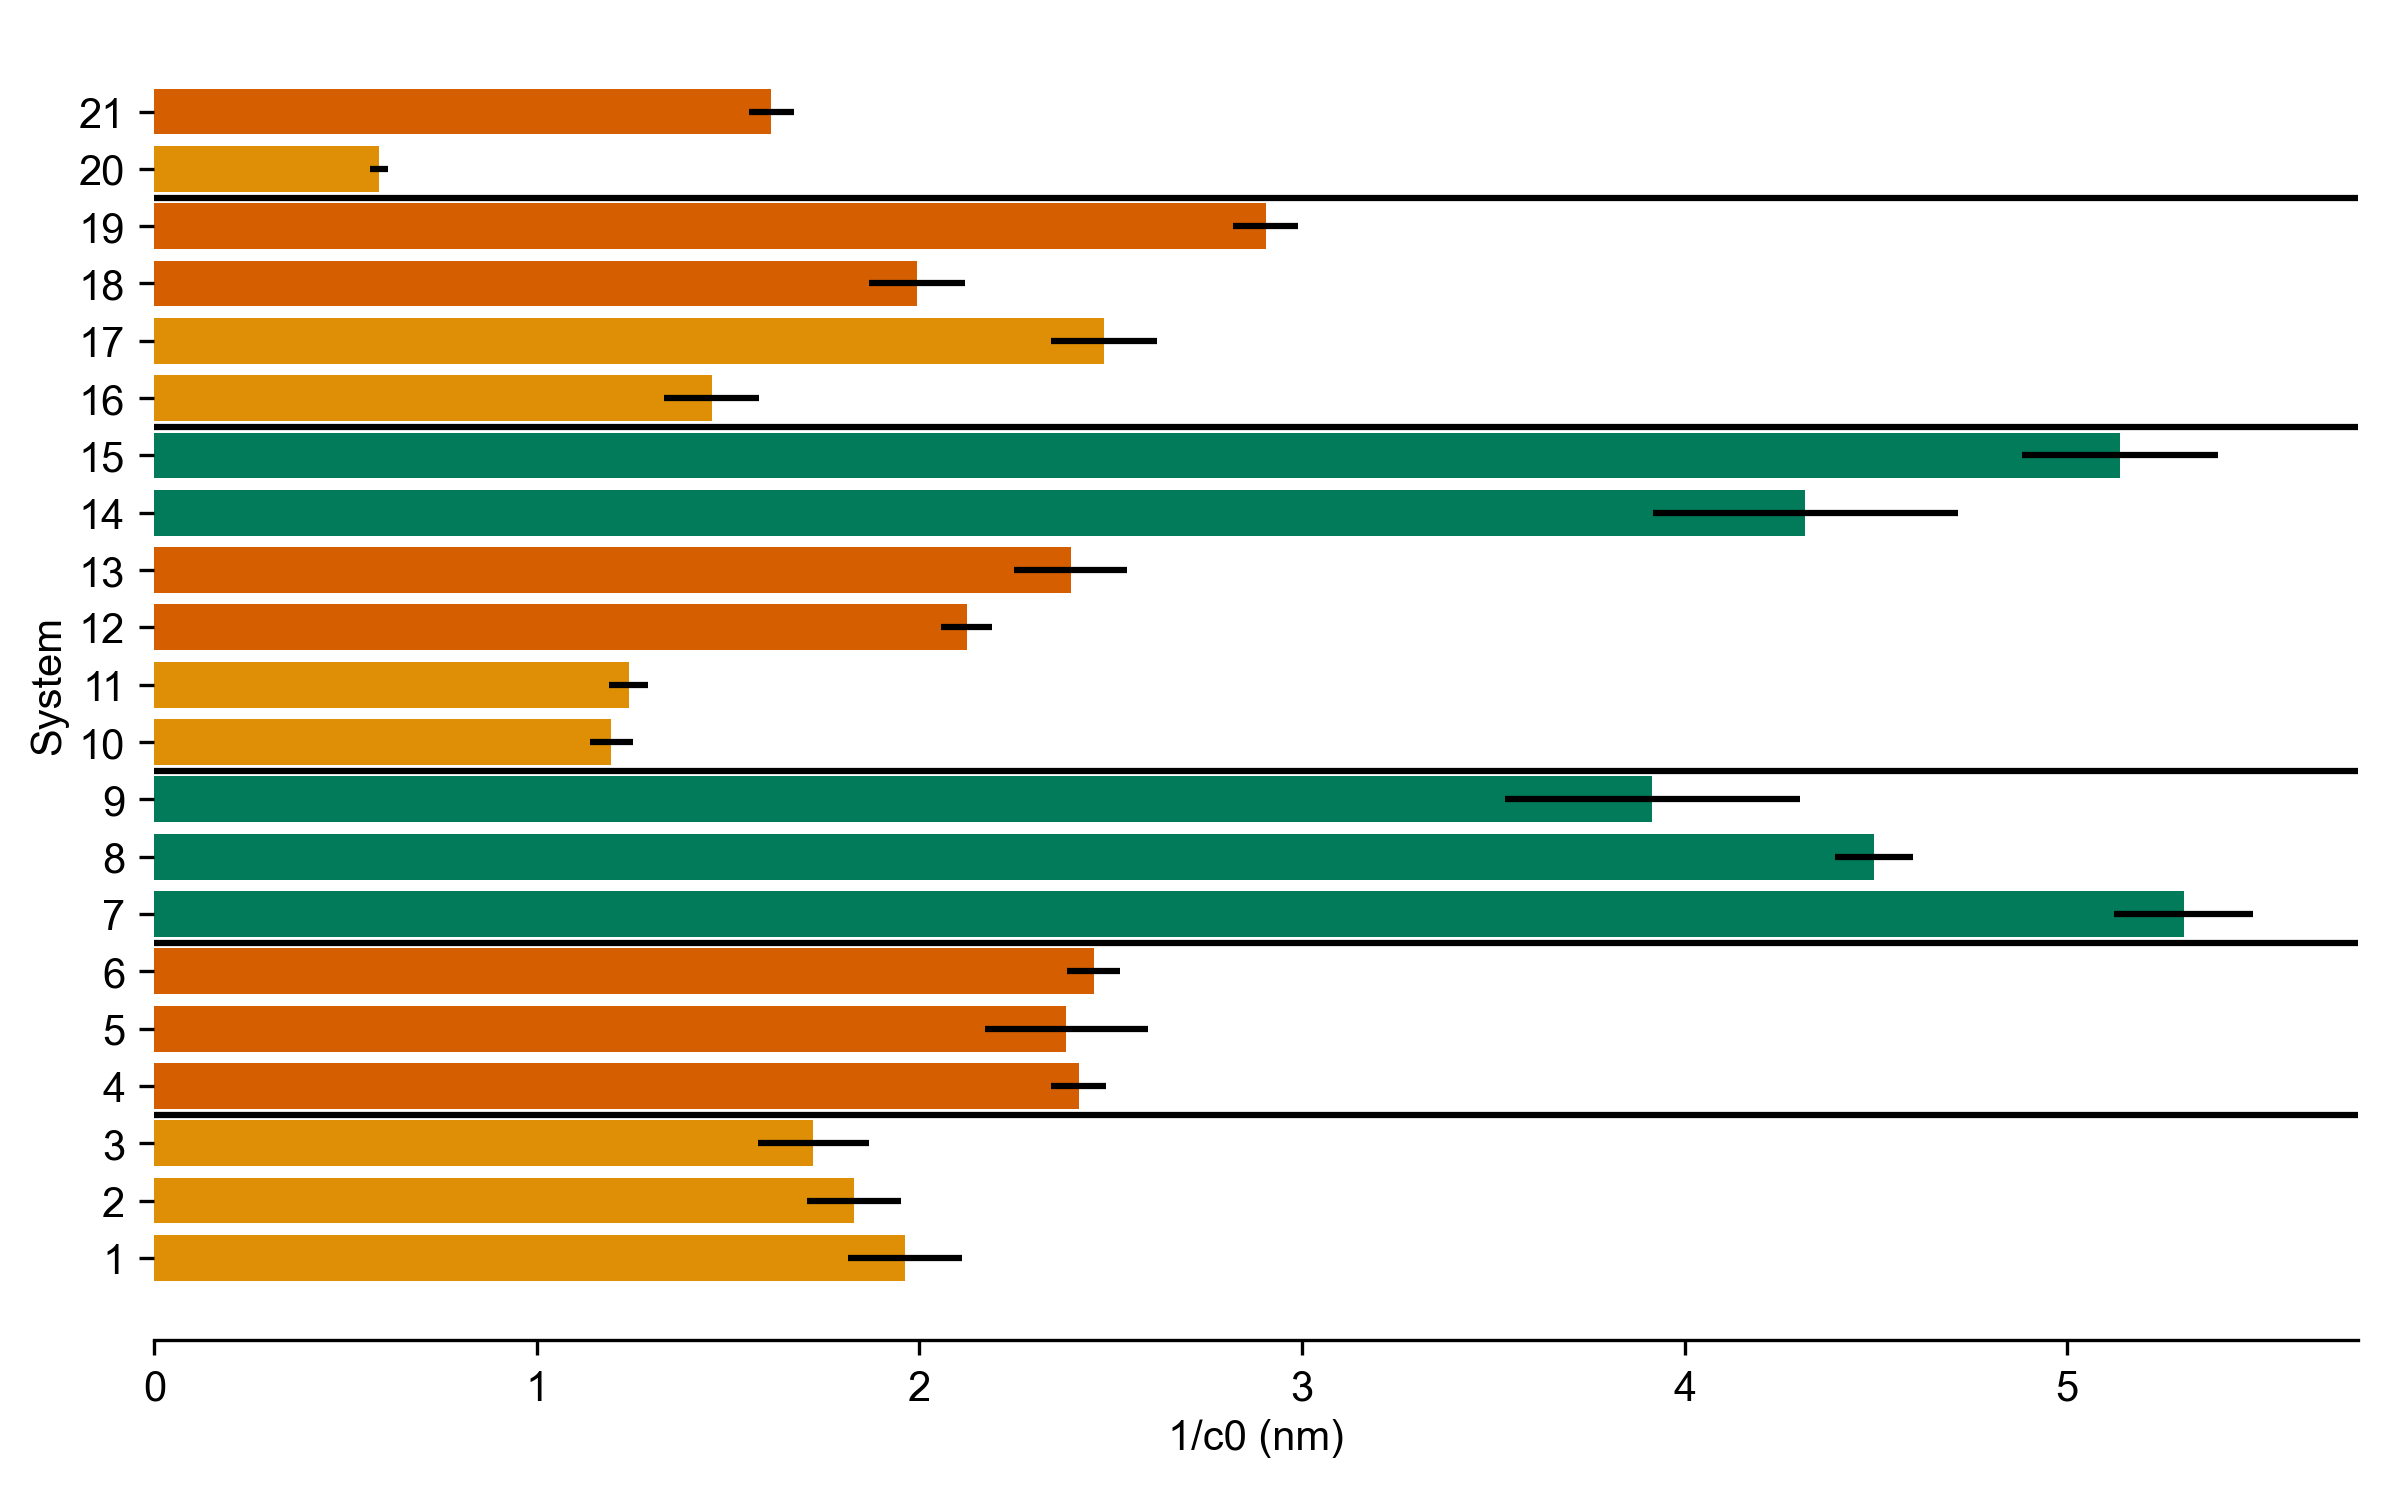

In [15]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(1, 4):
    ax.barh(str(i), one_over_c0[i][0], xerr=one_over_c0[i][1], color=pal[1], height=0.8)

for i in range(4, 7):
    ax.barh(str(i), one_over_c0[i][0], xerr=one_over_c0[i][1],color=pal[3], height=0.8)

for i in range(7, 10):
    ax.barh(str(i), one_over_c0[i][0], xerr=one_over_c0[i][1],color=lighten_color(pal[2], 1.1), height=0.8)

for i in range(10, 12):
    ax.barh(str(i), one_over_c0[i][0], xerr=one_over_c0[i][1],color=pal[1], height=0.8)

for i in range(12, 14):
    ax.barh(str(i), one_over_c0[i][0], xerr=one_over_c0[i][1],color=pal[3], height=0.8)

for i in range(14, 16):
    ax.barh(str(i), one_over_c0[i][0], xerr=one_over_c0[i][1],color=lighten_color(pal[2], 1.1), height=0.8)


for i in range(16, 18):
    ax.barh(str(i), one_over_c0[i][0], xerr=one_over_c0[i][1],color=pal[1], height=0.8)


for i in range(18, 20):
    ax.barh(str(i), one_over_c0[i][0], xerr=one_over_c0[i][1],color=pal[3], height=0.8)


ax.barh("20", one_over_c0[20][0], xerr=one_over_c0[20][1],color=pal[1], height=0.8)

ax.barh("21", one_over_c0[21][0], xerr=one_over_c0[21][1],color=pal[3], height=0.8)


ax.axhline(2.5, color="k")
ax.axhline(5.5, color="k")
ax.axhline(8.5, color="k")
ax.axhline(14.5, color="k")
ax.axhline(18.5, color="k")

ax.set_xlabel(r"1/c0 (nm)")
ax.set_ylabel(r"System")

# ax.set_xlim(0, 40)

# ax.set_xticklabels(
#     ax.get_xticks(),
# )

# x_ticks_labels = [f"{sim}" for sim in range(1,22)]

# Set number of ticks for x-axis
# ax.set_xticks(range(21))
# Set ticks labels for x-axis
# ax.set_xticklabels(x_ticks_labels)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

fig.tight_layout()

fig.savefig(curr_fig_path / f"spontaneous_curvature.png", format="png")
fig.savefig(curr_fig_path / f"spontaneous_curvature.pdf", format="pdf")

if show_figs:
    plt.show()

fig.clear()
plt.close(fig)


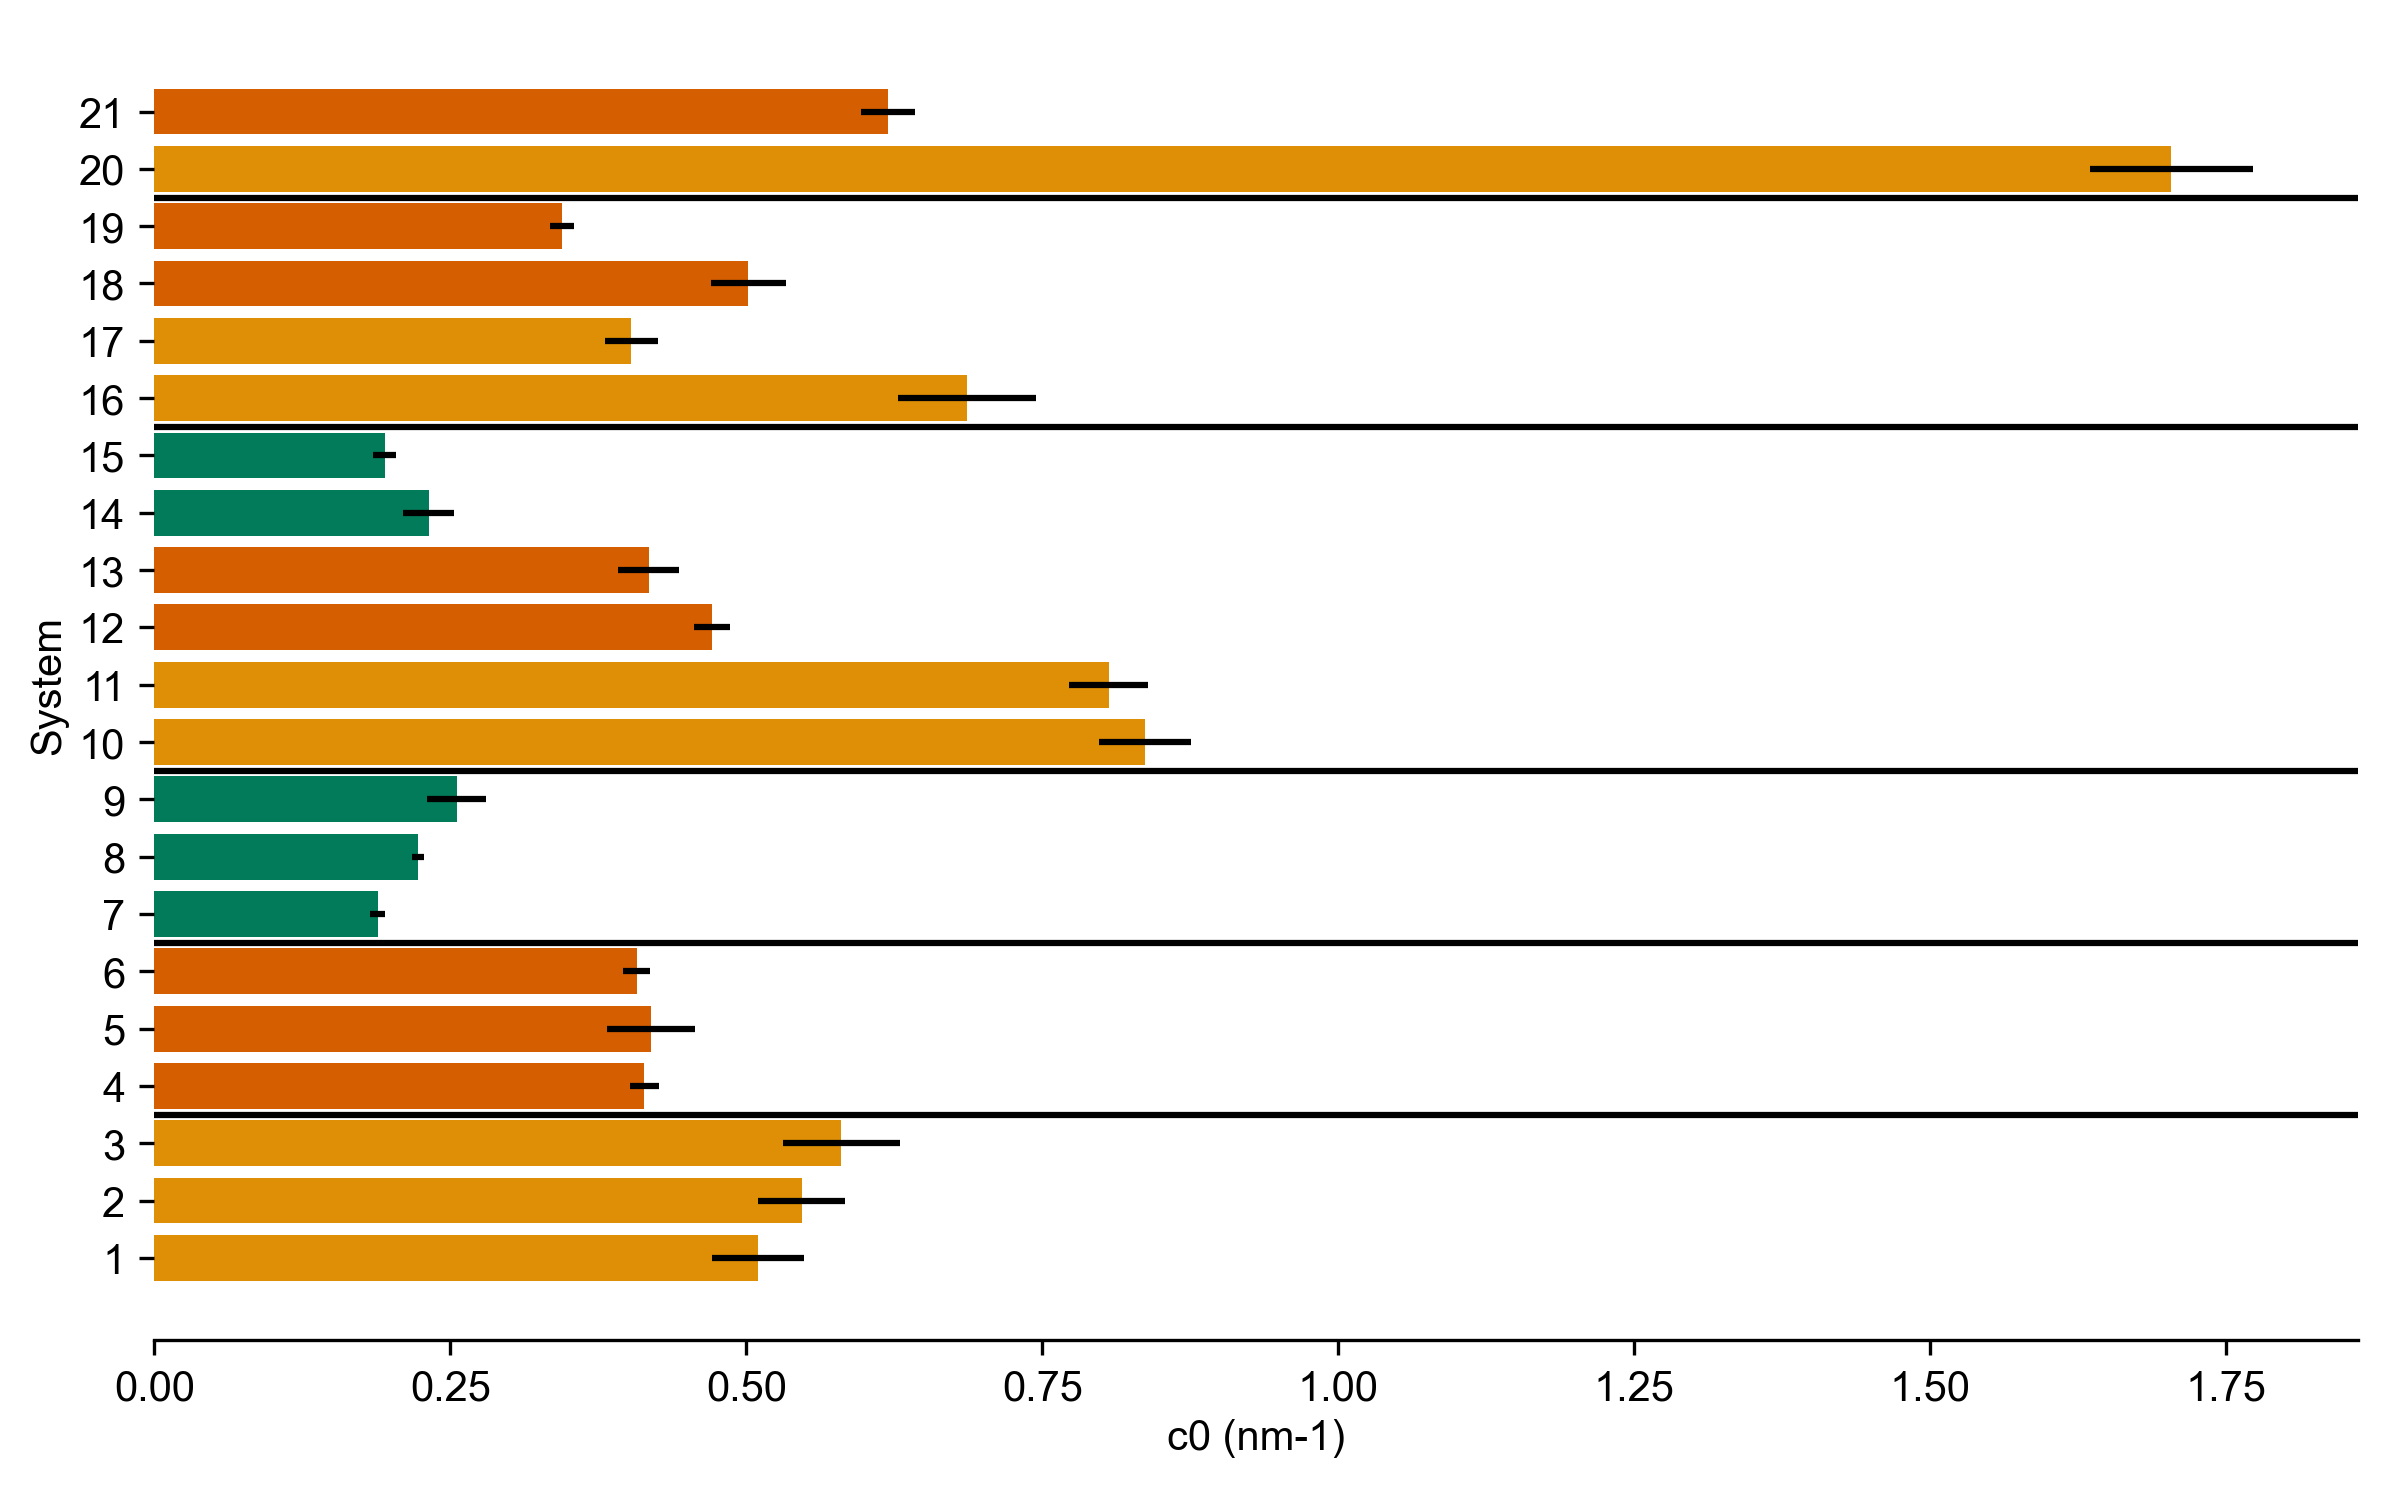

In [35]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(1, 4):
    ax.barh(str(i), c0[i][0], xerr=c0[i][1], color=pal[1], height=0.8)

for i in range(4, 7):
    ax.barh(str(i), c0[i][0], xerr=c0[i][1],color=pal[3], height=0.8)

for i in range(7, 10):
    ax.barh(str(i), c0[i][0], xerr=c0[i][1],color=lighten_color(pal[2], 1.1), height=0.8)

for i in range(10, 12):
    ax.barh(str(i), c0[i][0], xerr=c0[i][1],color=pal[1], height=0.8)

for i in range(12, 14):
    ax.barh(str(i), c0[i][0], xerr=c0[i][1],color=pal[3], height=0.8)

for i in range(14, 16):
    ax.barh(str(i), c0[i][0], xerr=c0[i][1],color=lighten_color(pal[2], 1.1), height=0.8)


for i in range(16, 18):
    ax.barh(str(i), c0[i][0], xerr=c0[i][1],color=pal[1], height=0.8)


for i in range(18, 20):
    ax.barh(str(i), c0[i][0], xerr=c0[i][1],color=pal[3], height=0.8)


ax.barh("20", c0[20][0], xerr=c0[20][1],color=pal[1], height=0.8)

ax.barh("21", c0[21][0], xerr=c0[21][1],color=pal[3], height=0.8)


ax.axhline(2.5, color="k")
ax.axhline(5.5, color="k")
ax.axhline(8.5, color="k")
ax.axhline(14.5, color="k")
ax.axhline(18.5, color="k")

ax.set_xlabel(r"c0 (nm-1)")
ax.set_ylabel(r"System")

# ax.set_xlim(0, 40)

# ax.set_xticklabels(
#     ax.get_xticks(),
# )

# x_ticks_labels = [f"{sim}" for sim in range(1,22)]

# Set number of ticks for x-axis
# ax.set_xticks(range(21))
# Set ticks labels for x-axis
# ax.set_xticklabels(x_ticks_labels)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

fig.tight_layout()

fig.savefig(curr_fig_path / f"spontaneous_curvature.png", format="png")
fig.savefig(curr_fig_path / f"spontaneous_curvature.pdf", format="pdf")

if show_figs:
    plt.show()

fig.clear()
plt.close(fig)


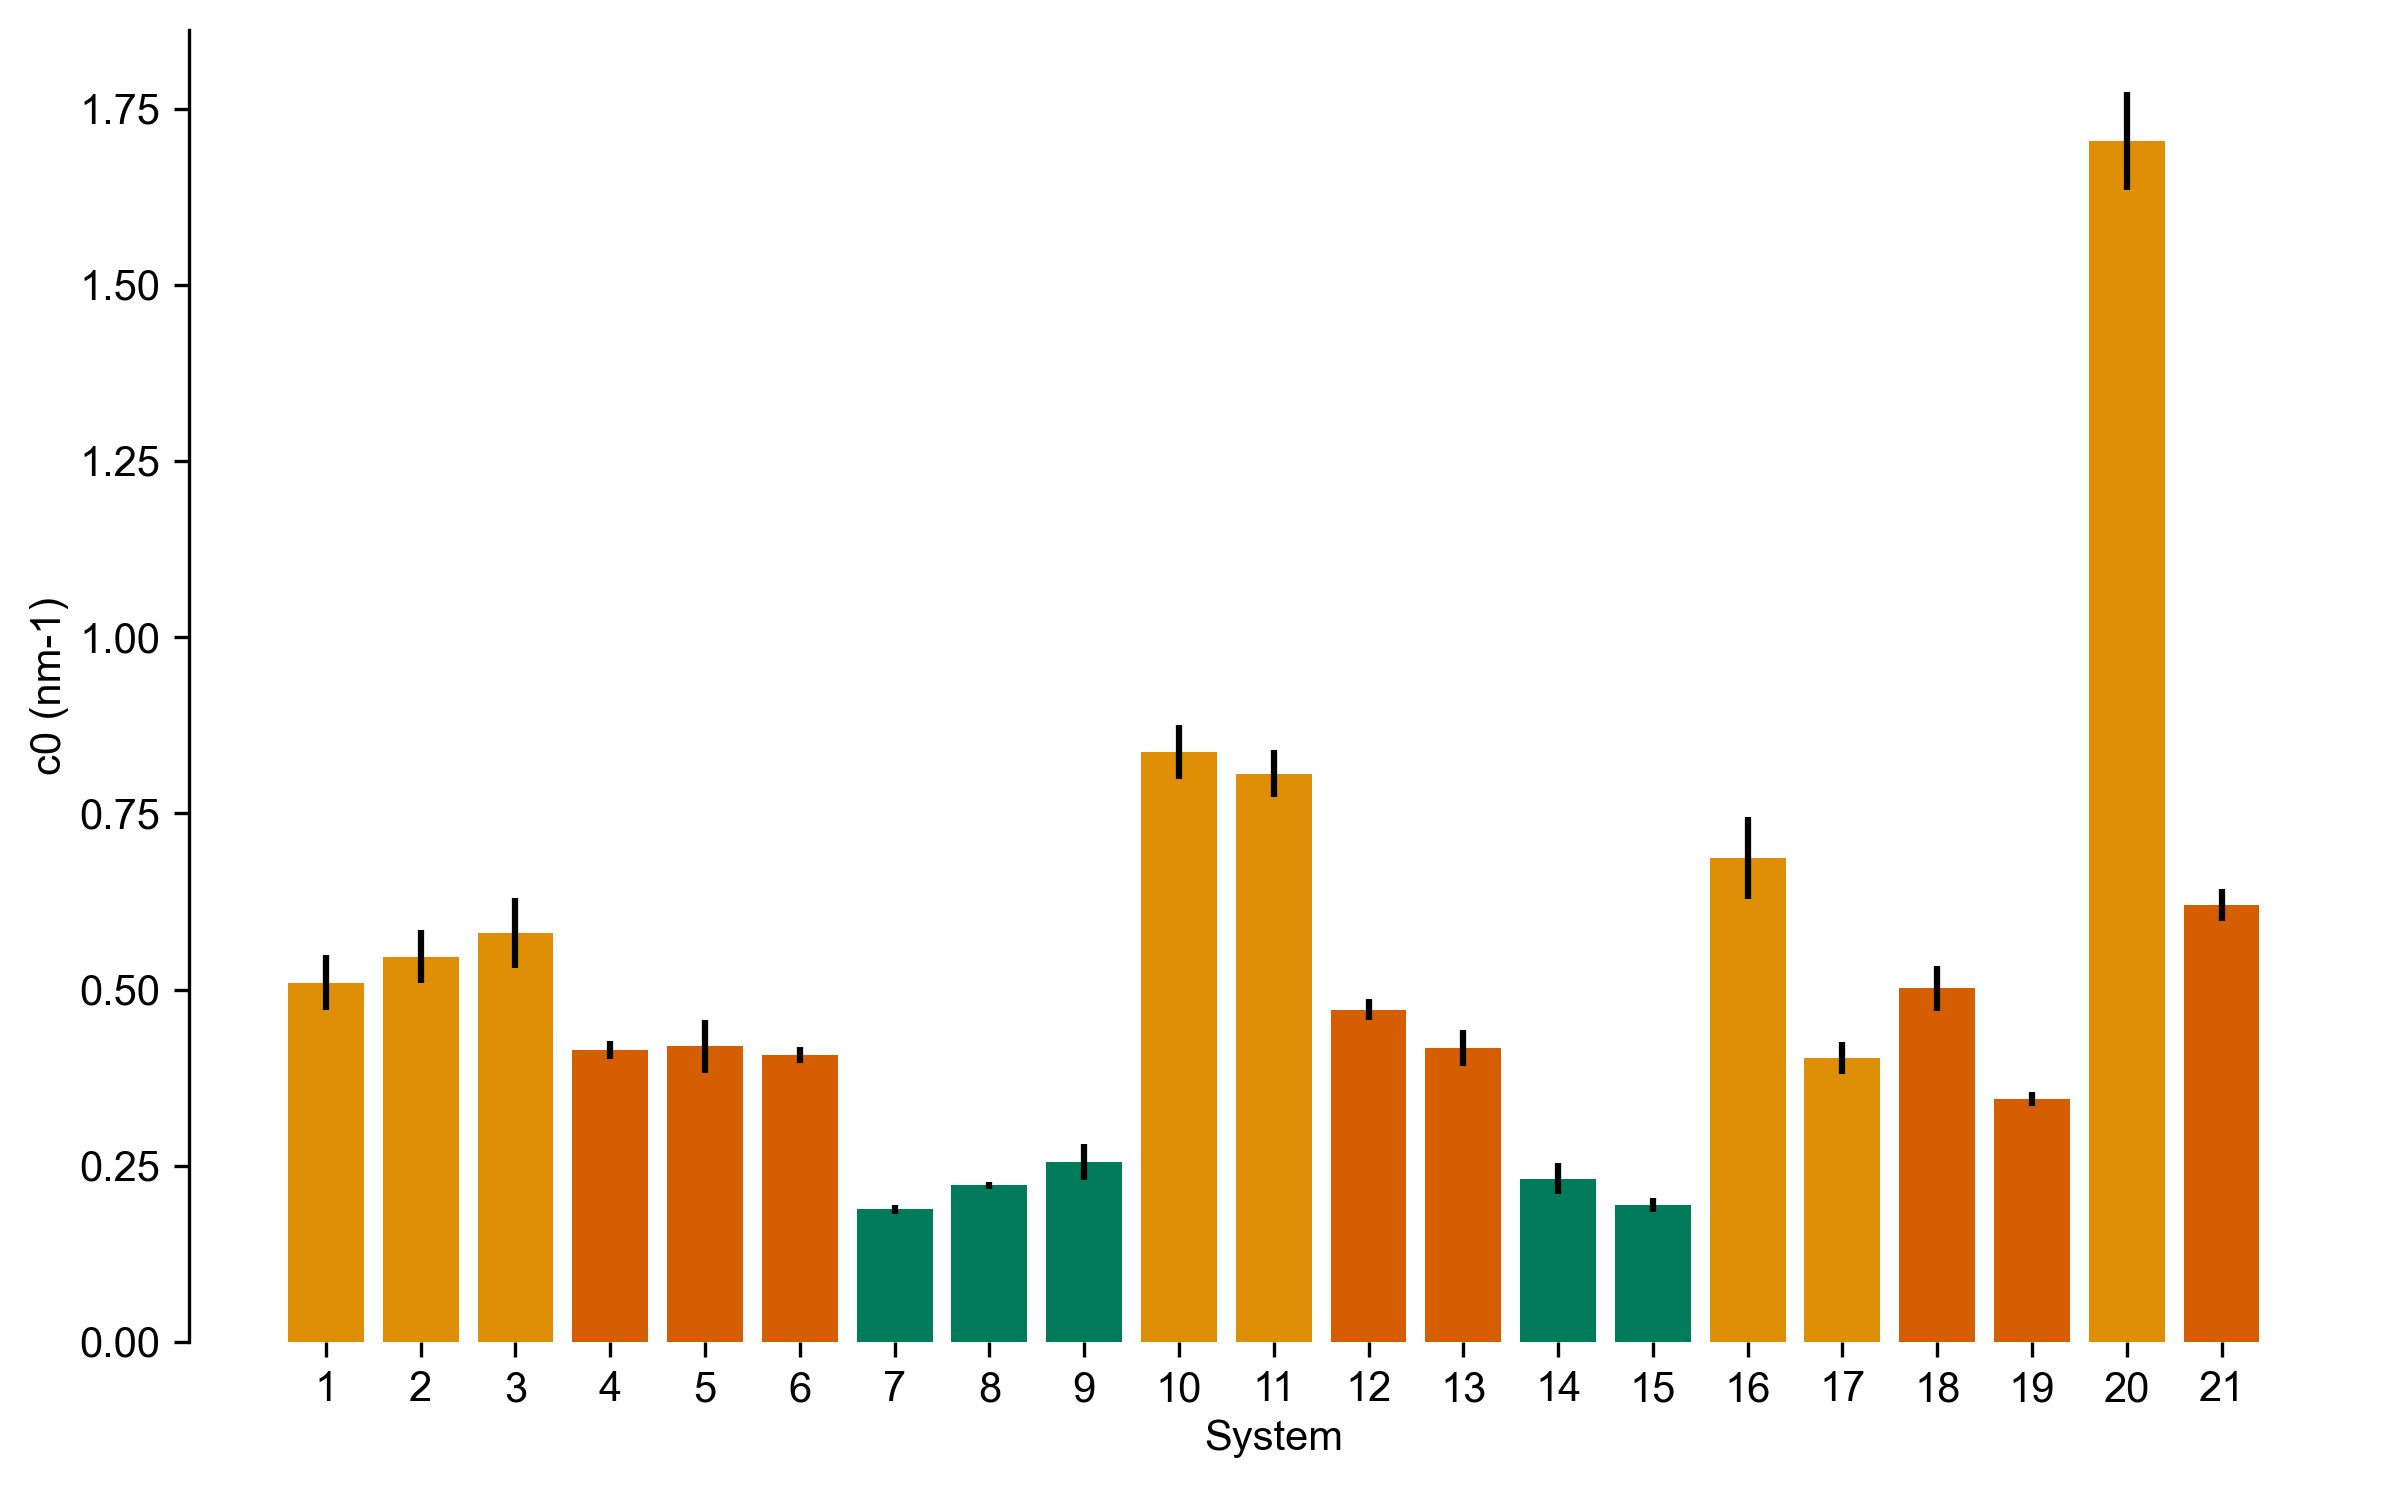

In [38]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i in range(1, 4):
    ax.bar(str(i), c0[i][0], yerr=c0[i][1], color=pal[1], )

for i in range(4, 7):
    ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

for i in range(7, 10):
    ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=lighten_color(pal[2], 1.1), )

for i in range(10, 12):
    ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[1], )

for i in range(12, 14):
    ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

for i in range(14, 16):
    ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=lighten_color(pal[2], 1.1), )


for i in range(16, 18):
    ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[1], )


for i in range(18, 20):
    ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )


ax.bar("20", c0[20][0], yerr=c0[20][1],color=pal[1], )

ax.bar("21", c0[21][0], yerr=c0[21][1],color=pal[3], )


# ax.axhline(2.5, color="k")
# ax.axhline(5.5, color="k")
# ax.axhline(8.5, color="k")
# ax.axhline(14.5, color="k")
# ax.axhline(18.5, color="k")

ax.set_ylabel(r"c0 (nm-1)")
ax.set_xlabel(r"System")

# ax.set_xlim(0, 40)

# ax.set_xticklabels(
#     ax.get_xticks(),
# )

# x_ticks_labels = [f"{sim}" for sim in range(1,22)]

# Set number of ticks for x-axis
# ax.set_xticks(range(21))
# Set ticks labels for x-axis
# ax.set_xticklabels(x_ticks_labels)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)


fig.tight_layout()

fig.savefig(curr_fig_path / f"spontaneous_curvature.png", format="png")
fig.savefig(curr_fig_path / f"spontaneous_curvature.pdf", format="pdf")

if show_figs:
    plt.show()

fig.clear()
plt.close(fig)


In [16]:
# f_cubic_dat = {}
# z_cubic_dat = {}
# msd_dat = {}

# for sim in util.simulations:
#     try:
#         data = np.mean(lateral_pressure[sim], axis=0)

#         z = data[:, 2]
#         lp = data[:, 1]
#         szz = data[:, 0]

#         fcd = first_cubic_np(z, lp)
#         f_cubic_dat[sim] = (
#             first_cubic_np(z, lp, maxz=0)[0] - first_cubic_np(z, lp, minz=0)[0]
#         ) / 2
#         # print(first_cubic(z, lp, minz=0)[0], first_cubic(z, lp, maxz=0)[0])

#         zcd = zero_cubic_np(z, lp)
#         z_cubic_dat[sim] = zero_cubic_np(z, lp)[0]

#         msd = mean_squared_deviation_np(szz)
#         msd_dat[sim] = msd
#         print(
#             f"{util.system_names[sim]}\n" f"         Zero Moment (pN/nm): {zcd}\n",
#             f"          First Moment (pN): {fcd}\n",
#             f"Monolayer First Moment (pN): {f_cubic_dat[sim]} {first_cubic_np(z, lp, maxz=0)[0]} {first_cubic_np(z, lp, minz=0)[0]}\n",
#             f"                MSD (kPa^2): {msd}\n",
#             f"      Upper Leaflet Tension: {zero_cubic_np(z, lp, minz=0)}\n",
#             f"      Lower Leaflet Tension: {zero_cubic_np(z, lp, maxz=0)}\n",
#         )
#     except Exception as e:
#         print(
#             f"{util.system_names[sim]}\n" f"{e}\n",
#         )
# np.save("f_cubic_dat.npy", f_cubic_dat)
# np.save("z_cubic_dat.npy", z_cubic_dat)
# np.save("msd_dat.npy", msd_dat)
